<a href="https://colab.research.google.com/github/SamPIngram/uncertain_ground_truth_experiments/blob/main/tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Evaluation and calibration with uncertain ground truth

This tutorial goes through Google DeepMind's [Uncertain Ground Truth (UGT)](https://github.com/google-deepmind/uncertain_ground_truth) framework for evaluating and calibrating machine learning models under uncertain ground truth. The tutorial is based on the paper [Conformal prediction under ambiguous ground truth](https://openreview.net/forum?id=CAd6V2qXxc) [1] and the case study [Evaluating AI systems under uncertain ground truth: a case study in dermatology](https://arxiv.org/abs/2307.02191) [2]. It will be explained in detail with a specific context to healthcare.

The tutorial will look to explain how the approach can be used to other experimental settings, and how it can be used to evaluate and calibrate machine learning models. For ease it can be run in colab (click below) or you can run the setup commands in the terminal within a virtual enviroment.

Many application domains, such as medical ones, require resonable uncertainty estimates for the decision making from models. This helps ensure best practices can be followed and/or formed and allows the Clinican to understand the risk to perform clinical decision making. To enable this, Conformal Prediction (CP) which is a statistical framework can be used to allow for rigorous uncertainty quantification in a performant manner. First introducted by [Vovk et al. (2005)](https://link.springer.com/book/10.1007/b106715), CP has becomes very popular within machine learning and can be applied to most data without the need of certain distributional or model assumptions. For further details on Conformal Prediction please check out [Anastasios N. Angelopoulos & Stephen Bates - A Gentle Introduction to Conformal Prediction and Distribution-Free Uncertainty Quantification](https://people.eecs.berkeley.edu/~angelopoulos/blog/posts/gentle-intro/) for one of the best overviews.

# 1. Setup

In [ ]:
!git clone https://github.com/google-deepmind/uncertain_ground_truth.git
!pip install tensorflow tensorflow-datasets absl-py scikit-learn jax jupyter matplotlib
!cd uncertain_ground_truth && python -m unittest discover -s . -p '*_test.py'

# 2. Creating a Toy Dataset

*Currently based on Deepmind's [colab_toy_data notebook](https://github.com/google-deepmind/uncertain_ground_truth/blob/main/colab_toy_data.ipynb), but will be updated*

In [ ]:
import jax
import jax.numpy as jnp
import matplotlib
from matplotlib import pyplot as plt
import numpy as np
import os
import pickle
import sklearn.neural_network

In [ ]:
%cd /content/uncertain_ground_truth
import formats
import irn as aggregation
import gaussian_toy_dataset as gtd
import colab_utils

/content/uncertain_ground_truth


In [ ]:
colab_utils.set_style()
plot_hist = colab_utils.plot_hist

### Data
The Gaussian toy dataset samples examples from multiple overlapping Gaussians, see gaussian_toy_dataset.py for details.

Here, we create the 2-dimensional reference examples used in [1] for illustrative purposes and an easy way to play around with this repository.

In [ ]:
def get_data(config):
  """Generate data using the config."""
  # Defines a dataset of multiple overlapping Gaussians.
  generator = gtd.GaussianToyDataset(
      config['rng'], jnp.array(config['class_weights']),
      config['class_sigmas'], config['dimensionality'], config['sigma'])
  num_examples = config['train_examples'] + config['test_examples']
  # Sample points x from the overlapping Gaussian distributions.
  examples, ground_truths = generator.sample_points(num_examples)
  # Compute the true posterior distributions p(y|x).
  human_ground_truths = generator.evaluate_points(examples)
  # Sample annotator rankings for all points.
  rankings, groups = generator.sample_rankings(
      human_ground_truths,
      config['reader_sharpness'],
      config['expected_length'],
      config['grouping_threshold'])
  # Convert rankings and compute IRN aggregation.
  selectors = formats.convert_rankings_to_selectors(rankings, groups)
  irn = aggregation.aggregate_irn(rankings, groups)
  return {
      'config': config,
      'train_examples': examples[:config['train_examples']],
      'train_labels': ground_truths[:config['train_examples']],
      'train_smooth_labels': human_ground_truths[:config['train_examples']],
      'train_rankings': rankings[:config['train_examples']],
      'train_groups': groups[:config['train_examples']],
      'train_selectors': selectors[:config['train_examples']],
      'train_irn': irn[:config['train_examples']],
      'test_examples': examples[config['train_examples']:],
      'test_labels': ground_truths[config['train_examples']:],
      'test_smooth_labels': human_ground_truths[config['train_examples']:],
      'test_rankings': rankings[config['train_examples']:],
      'test_groups': groups[config['train_examples']:],
      'test_selectors': selectors[config['train_examples']:],
      'test_irn': irn[config['train_examples']:],
  }

In [ ]:
config = {}
config['rng'] = gtd.PRNGSequence(5)
config['dimensionality'] = 2
config['sigma'] = 0.3
config['class_weights'] = [1]*3
config['class_sigmas'] = 0.1
config['train_examples'] = 1000
# Note that in the paper we used 20000 test examples.
config['test_examples'] = 1000
config['expected_length'] = 1.5
config['grouping_threshold'] = 0.05
# Number of readers and their sharpness.
config['reader_sharpness'] = jnp.array([500000, 100000, 50000, 1000000, 500000, 150000, 100000, 1000000, 100000, 90000])

In [ ]:
data = get_data(config)

/content/uncertain_ground_truth/colab_utils.py:235: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(


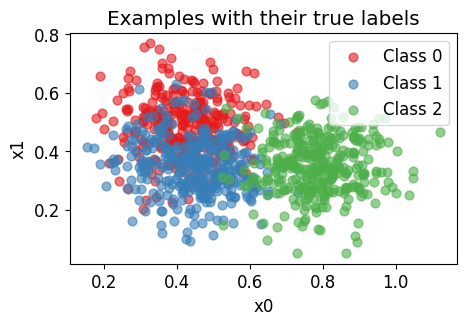

In [ ]:
colors = np.array([
    [228,26,28],
    [55,126,184],
    [77,175,74],
]) / 255.
colab_utils.plot_data(
    data['train_examples'], data['train_labels'],
    title='Examples with their true labels', name='data', colors=colors)

/content/uncertain_ground_truth/colab_utils.py:235: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(


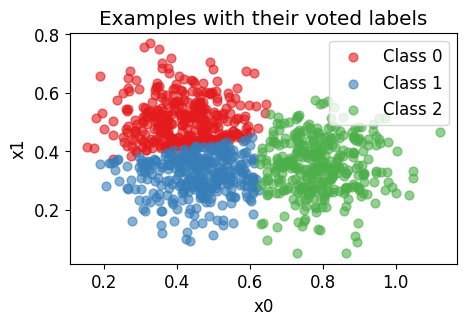

In [ ]:
colab_utils.plot_data(
    data['train_examples'],
    np.argmax(data['train_smooth_labels'], axis=1),
    title='Examples with their voted labels', name='data_top1', colors=colors)

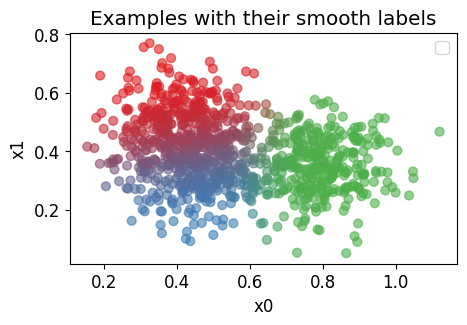

In [ ]:
colab_utils.plot_smooth_data(
      data['train_examples'], data['train_smooth_labels'], name='data_smooth', colors=colors)

In [ ]:
%cd /content/
with open('toy_data.pkl', 'wb') as f:
  pickle.dump(data, f)

/content


### Model
We train a small MLP. Note that in the paper, we trained our own 2-layer MLP using Haiku; for simplicty this Colab uses sklearn instead.

In [ ]:
predictions = []
for seed in range(4):
  classifier = sklearn.neural_network.MLPClassifier(alpha=1, max_iter=(seed + 1) * 25, random_state=seed)
  classifier.fit(
      data['train_examples'],
      jax.nn.one_hot(data['train_labels'], 3))
  predictions_k = classifier.predict_log_proba(data['test_examples'])
  predictions_k = jax.nn.softmax(predictions_k)
  predictions.append(predictions_k)
predictions = jnp.array(predictions)

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (25) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (75) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


In [ ]:
for seed in range(predictions.shape[0]):
    print(seed, jnp.mean(data['test_labels'] == jnp.argmax(predictions[seed], axis=1)))
    with open(f'toy_predictions{seed}.pkl', 'wb') as f:
        pickle.dump(predictions[seed], f)

0 0.69200003
1 0.77000004
2 0.76400006
3 0.78200006
